# 다항회귀분석 연습문제

다항식 만든 후 표준화

## #01. 패키지 준비하기

In [2]:
import sys
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## #02. 데이터셋 준비하기

In [3]:
origin = read_excel("https://data.hossam.kr/F02/fish2.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


## #03. 데이터 전처리

### 결측치 확인

In [4]:
origin.isnull().sum()

길이    0
높이    0
두께    0
무게    0
dtype: int64

## #04. 탐색적 데이터 분석

### 기본통계 확인

In [5]:
origin.describe()

,길이,높이,두께,무게
count,56.000000,56.000000,56.000000,56.000000
mean,27.892857,7.862143,4.745536,382.239286
std,9.021668,2.878343,1.775006,347.617717
min,8.400000,2.110000,1.410000,5.900000
25%,21.825000,5.690000,3.520000,120.000000
50%,25.300000,6.920000,4.155000,207.500000
75%,36.625000,10.850000,6.450000,692.500000
max,44.000000,12.800000,8.140000,1100.000000


### 산점도 그래프와 추세선 확인

In [6]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (30,30)
plt.rcParams['axes.unicode_minus'] = False

c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


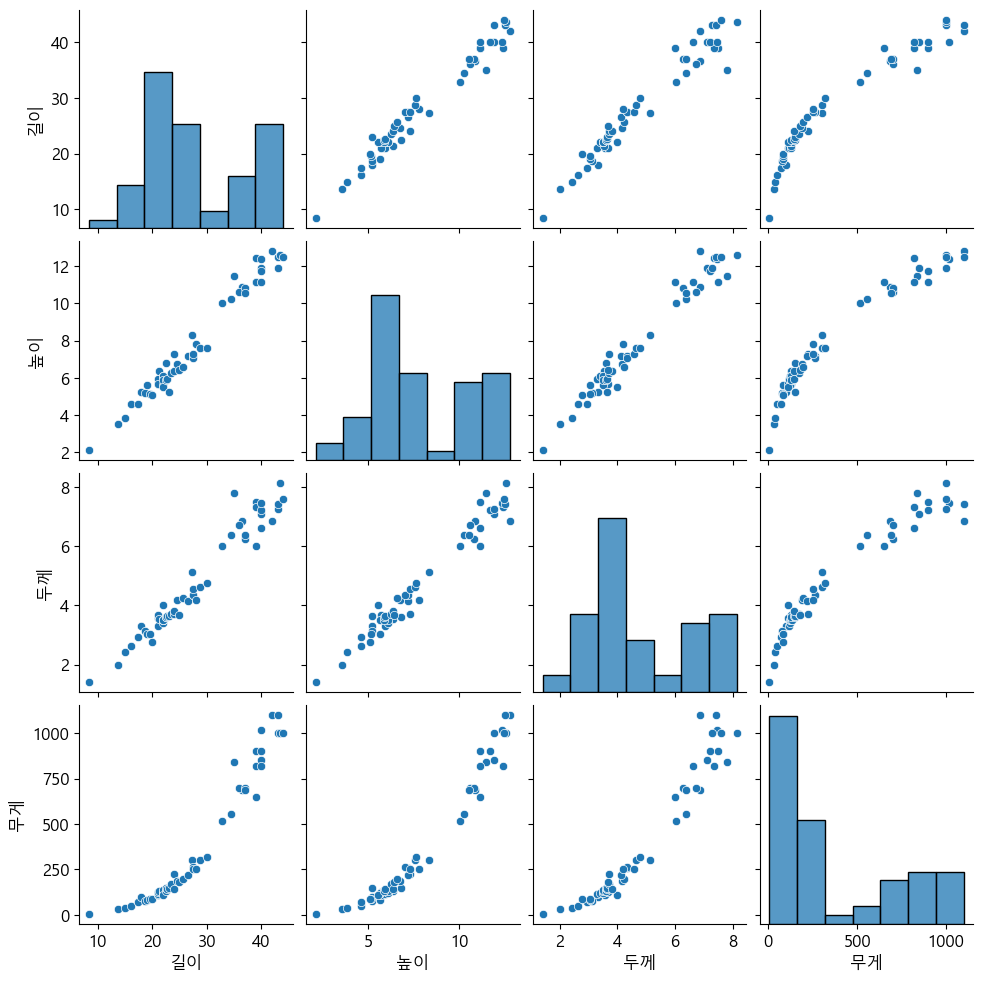

In [7]:
sb.pairplot(origin)
plt.show()
plt.close()

> 다항식이 적합해보인다.

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [8]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [9]:
x = origin[['길이','높이','두께']]
y = origin[['무게']]
x.shape, y.shape

((56, 3), (56, 1))

### 독립변수를 다항식으로 변환

In [10]:
poly = PolynomialFeatures(degree=2, include_bias=False)
fit = poly.fit_transform(x)
x2 = DataFrame(fit, columns=poly.get_feature_names_out())
x2.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2
0,8.4,2.11,1.41,70.56,17.724,11.844,4.4521,2.9751,1.9881
1,13.7,3.53,2.00,187.69,48.361,27.400,12.4609,7.0600,4.0000
2,15.0,3.82,2.43,225.00,57.300,36.450,14.5924,9.2826,5.9049
3,16.2,4.59,2.63,262.44,74.358,42.606,21.0681,12.0717,6.9169
4,17.4,4.59,2.94,302.76,79.866,51.156,21.0681,13.4946,8.6436


### 데이터 표준화

### 훈련 데이터와 검증 데이터로 분할

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x2,y,test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 9), (17, 9), (39, 1), (17, 1))

In [12]:
len(x_train.iloc[0])

9

## #06. 모델 개발

### 모델 정의

In [13]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫번째 Dense 층
# input_shape = 독립변수의 갯수 (길이, 높이, 두께) = >3개
model.add(Dense(64, activation = 'relu', input_shape=(len(x_train.iloc[0]), )))

# 은닉층
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
# 마지막 층
model.add(Dense(1, activation='linear'))

model.compile(optimizer = 'adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dense_5 (Dense)             (None, 2)                 10        
                                                                 
 dense_6 (Dense)             (None, 1)                 3

### 학습하기

 validation_data=여러 분석 모델 중 어떤 모델이 적합한지 선택하기 위한 검증용 데이터

callback 함수 파라미터 : 

monitor : 학습 조기종료를 위해 관찰하는 항목입니다. val_loss 나 val_accuracy 가 주로 사용됩니다. (default : val_loss)

patience : 개선이 안된다고 바로 종료시키지 않고, 개선을 위해 몇번의 에포크를 기다릴지 설정합니다. (default = 0)

patience: Number of epochs with no improvement after which training will be stopped. verbose: Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.

In [14]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500


2/2 [==============================] - 1s 178ms/step - loss: 313964.0625 - mae: 420.2576 - val_loss: 238319.1250 - val_mae: 366.3766 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 32ms/step - loss: 301843.5000 - mae: 410.4120 - val_loss: 232286.6562 - val_mae: 360.8846 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 24ms/step - loss: 294809.0312 - mae: 404.9548 - val_loss: 227255.9531 - val_mae: 356.3043 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 24ms/step - loss: 289477.8750 - mae: 400.5367 - val_loss: 223862.6406 - val_mae: 353.1971 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 33ms/step - loss: 285287.1875 - mae: 397.2935 - val_loss: 221810.9219 - val_mae: 351.2549 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 27ms/step - loss: 283509.4688 - mae: 395.7311 - val_loss: 221809.5625 - val_mae: 351.2530 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 32ms/step - los

## #07. 학습 결과 평가

In [15]:
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index + 1
result_df.set_index('epochs', inplace=True)
result_df

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,313964.06250,420.257599,238319.125000,366.376556,0.001
2,301843.50000,410.412048,232286.656250,360.884644,0.001
3,294809.03125,404.954834,227255.953125,356.304260,0.001
4,289477.87500,400.536682,223862.640625,353.197052,0.001
5,285287.18750,397.293549,221810.921875,351.254944,0.001
...,...,...,...,...,...
496,282755.46875,394.777252,221140.375000,350.299133,0.001
497,282753.93750,394.775299,221139.015625,350.297180,0.001
498,282752.34375,394.773346,221137.671875,350.295288,0.001


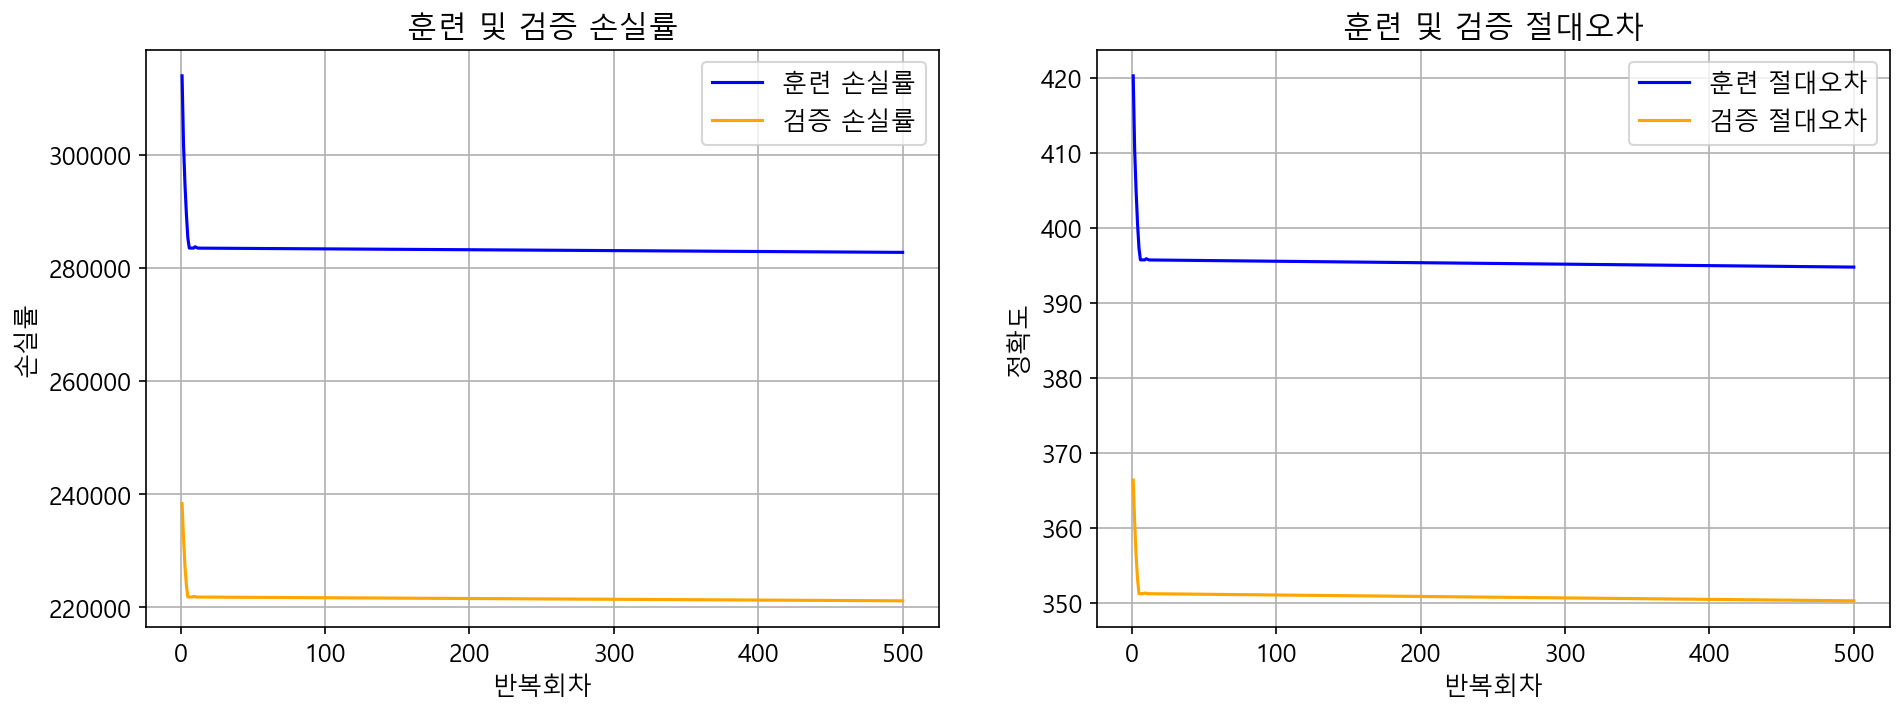

In [16]:
# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [17]:
evaluate1 = model.evaluate(x_train, y_train)
print('최종 훈련 손실률 : %f, 최종 훈련 절대오차: %f' % (evaluate1[0], evaluate1[1]))
evaluate2 = model.evaluate(x_test, y_test)
print('최종 훈련 손실률 : %f, 최종 훈련 절대오차: %f' % (evaluate2[0], evaluate2[1]))

2/2 [==============================] - 0s 4ms/step - loss: 282747.9375 - mae: 394.7677
최종 훈련 손실률 : 282747.937500, 최종 훈련 절대오차: 394.767700
1/1 [==============================] - 0s 16ms/step - loss: 221134.9375 - mae: 350.2914
최종 훈련 손실률 : 221134.937500, 최종 훈련 절대오차: 350.291382


## #08. 학습 결과 적용

### 테스트 데이터에 대한 예측 결과 산정

In [18]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 16ms/step


### 결과 데이터 셋 구성

In [19]:
x2.columns

Index(['길이', '높이', '두께', '길이^2', '길이 높이', '길이 두께', '높이^2', '높이 두께', '두께^2'], dtype='object')

In [20]:
train_df = DataFrame(x_train, columns=x2.columns)
train_df['무게(관측치)'] = y_train['무게'].values
train_df['무게(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['무게(관측치)'] - train_df['무게(예측치)']

train_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
8,19.6,5.14,3.04,384.16,100.744,59.584,26.4196,15.6256,9.2416,85.0,0.973324,84.026676
0,8.4,2.11,1.41,70.56,17.724,11.844,4.4521,2.9751,1.9881,5.9,0.973324,4.926676
15,22.0,5.64,3.52,484.00,124.080,77.440,31.8096,19.8528,12.3904,120.0,0.973324,119.026676
26,24.6,6.73,4.17,605.16,165.558,102.582,45.2929,28.0641,17.3889,188.0,0.973324,187.026676
51,42.0,12.80,6.87,1764.00,537.600,288.540,163.8400,87.9360,47.1969,1100.0,0.973324,1099.026676


In [21]:
test_df = DataFrame(x_test, columns=x2.columns)
test_df['무게(관측치)'] = y_test['무게'].values
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['무게(관측치)'] - test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
16,22.0,6.11,3.52,484.00,134.420,77.440,37.3321,21.5072,12.3904,130.0,0.973324,129.026676
12,21.0,5.69,3.67,441.00,119.490,77.070,32.3761,20.8823,13.4689,125.0,0.973324,124.026676
21,22.7,5.95,3.63,515.29,135.065,82.401,35.4025,21.5985,13.1769,145.0,0.973324,144.026676
33,27.5,7.28,4.57,756.25,200.200,125.675,52.9984,33.2696,20.8849,250.0,0.973324,249.026676
36,30.0,7.62,4.77,900.00,228.600,143.100,58.0644,36.3474,22.7529,320.0,0.973324,319.026676


### 실제 결과값과 머신러닝에 의한 예측값 비교

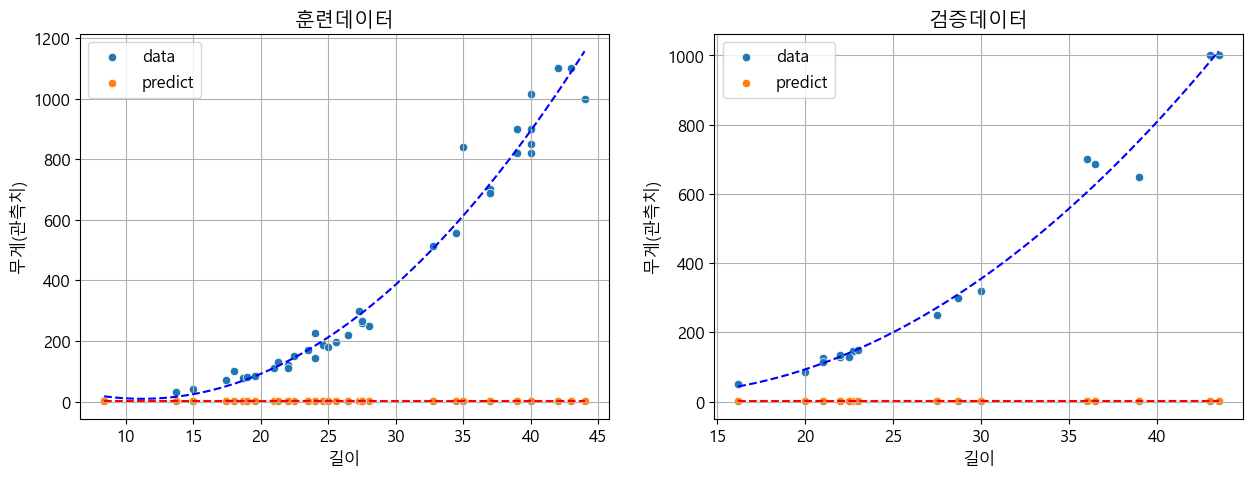

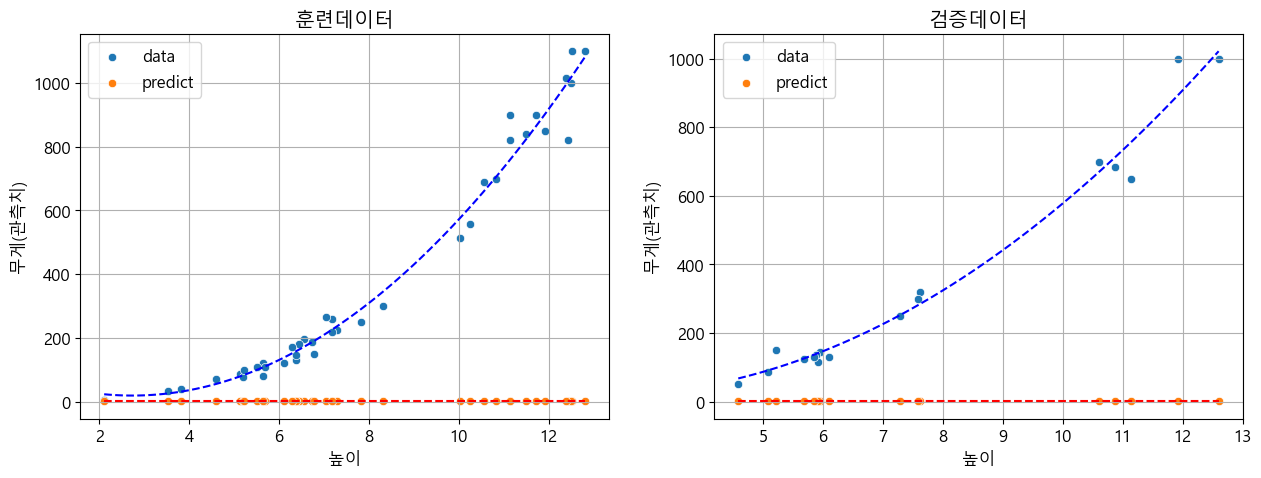

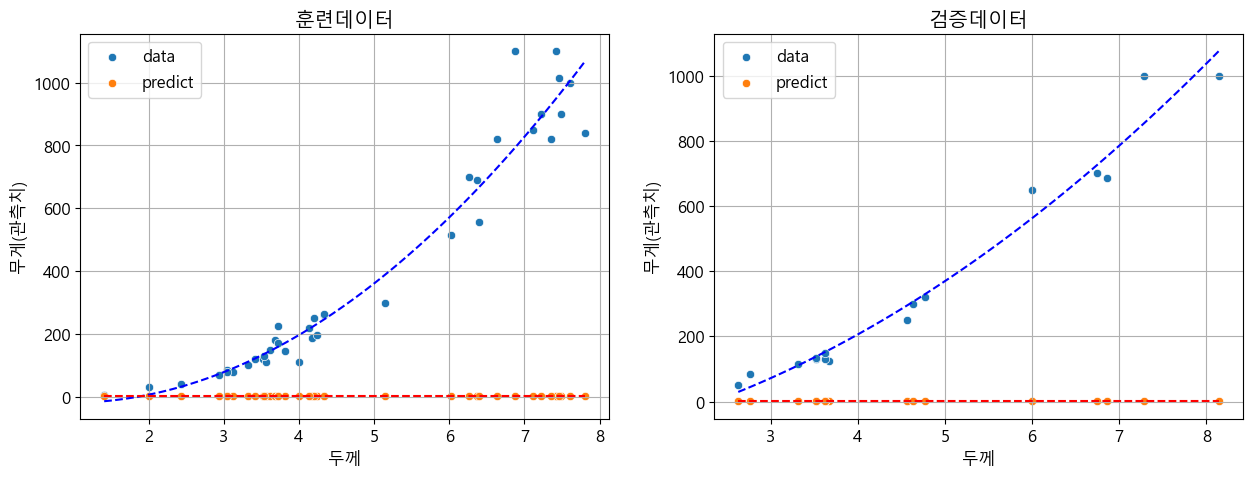

In [22]:
for key in ['길이','높이','두께']:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))


> 표준화 시켜보고 다시 해보기

## #09. 표준화 후 다시 진행

### 표준화

In [23]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x2)

# 종속변수를 표준화 하는 것을 권장하지 않는다.
# y_scaller = StandardScaler()
# y_scale = y_scaller.fit_transform(y)

# 머신러닝에서 종속변수 표준화해도 ok => epochs 수가 낮아진다.
x_scale.shape

(56, 9)

### 훈련데이터, 검증데이터 분할

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 9), (17, 9), (39, 1), (17, 1))

### 모델개발

In [25]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train[0]), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                640       
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2753 (10.75 KB)
Trainable params: 2753 (10.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500


2/2 [==============================] - 1s 121ms/step - loss: 283206.0000 - mae: 395.6217 - val_loss: 221473.3906 - val_mae: 351.0518 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 33ms/step - loss: 283065.8750 - mae: 395.4724 - val_loss: 221350.1250 - val_mae: 350.9152 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 32ms/step - loss: 282915.3438 - mae: 395.3243 - val_loss: 221238.7656 - val_mae: 350.7862 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 31ms/step - loss: 282773.2500 - mae: 395.1826 - val_loss: 221132.4062 - val_mae: 350.6600 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 33ms/step - loss: 282646.4062 - mae: 395.0483 - val_loss: 221027.9531 - val_mae: 350.5362 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 36ms/step - loss: 282524.0312 - mae: 394.9158 - val_loss: 220923.7500 - val_mae: 350.4136 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 23ms/step - los

### 학습결과 평가

In [27]:
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,283206.000000,395.621704,221473.390625,351.051758,0.001
2,283065.875000,395.472443,221350.125000,350.915222,0.001
3,282915.343750,395.324280,221238.765625,350.786163,0.001
4,282773.250000,395.182587,221132.406250,350.660034,0.001
5,282646.406250,395.048279,221027.953125,350.536163,0.001
...,...,...,...,...,...
176,10459.993164,84.598640,12728.773438,77.206169,0.001
177,10389.102539,84.143440,12750.166992,76.780251,0.001
178,10324.221680,83.620369,12774.521484,76.390785,0.001


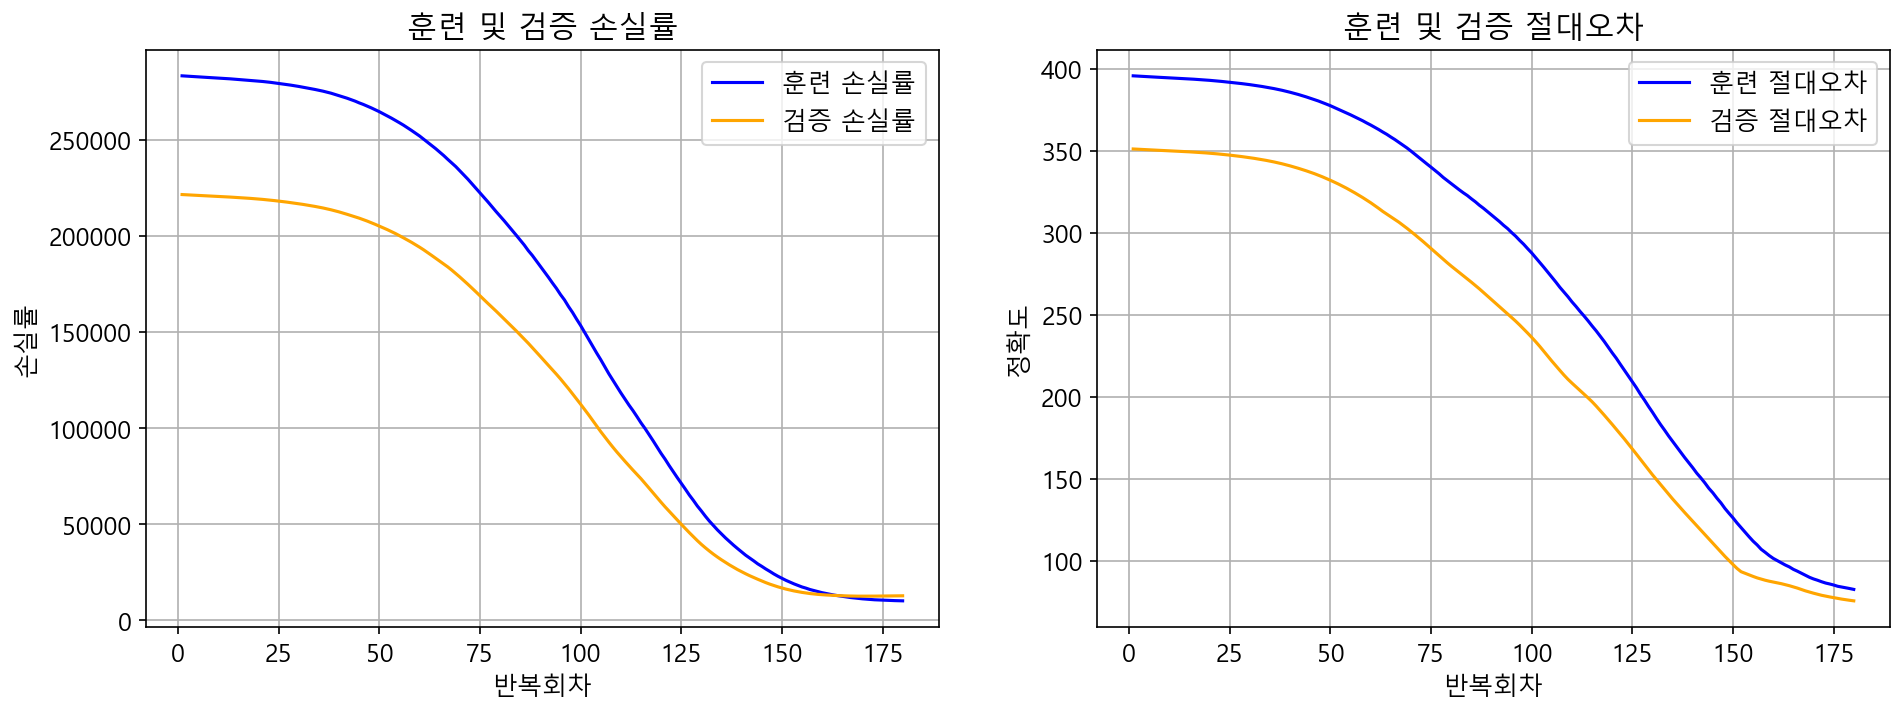

In [28]:
# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [29]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률:%f, 최종 훈련 절대오차:%f" %(evaluate1[0], evaluate1[1]))
evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률:%f, 최종 검증 절대오차:%f" %(evaluate2[0], evaluate2[1]))

2/2 [==============================] - 0s 0s/step - loss: 10172.5479 - mae: 82.3037
최종 훈련 손실률:10172.547852, 최종 훈련 절대오차:82.303711
1/1 [==============================] - 0s 24ms/step - loss: 12831.8164 - mae: 75.7245
최종 검증 손실률:12831.816406, 최종 검증 절대오차:75.724457


### 학습 결과 적용

테스트 데이터에 대한 예측 결과 산정

In [30]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

2/2 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 16ms/step


결과 데이터 셋 구성

In [31]:
x2.columns

Index(['길이', '높이', '두께', '길이^2', '길이 높이', '길이 두께', '높이^2', '높이 두께', '두께^2'], dtype='object')

In [32]:
train_df = DataFrame(x_train, columns=x2.columns)
train_df['무게(관측치)'] = y_train['무게'].values
train_df['무게(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['무게(관측치)']-train_df['무게(예측치)']

train_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
0,-0.927534,-0.954292,-0.969558,-0.901344,-0.905194,-0.910571,-0.902581,-0.905521,-0.901350,85.0,126.107063,-41.107063
1,-2.180225,-2.016507,-1.896175,-1.497943,-1.428186,-1.403939,-1.358064,-1.335908,-1.300665,5.9,182.888062,-176.988062
2,-0.659101,-0.779008,-0.696689,-0.711407,-0.758186,-0.726039,-0.790823,-0.761706,-0.728004,120.0,108.782433,11.217567
3,-0.368297,-0.396891,-0.327179,-0.480910,-0.496891,-0.466210,-0.511254,-0.482346,-0.452830,188.0,79.991753,108.008247
4,1.577847,1.731046,1.207709,1.723689,1.846825,1.455565,1.946749,1.554578,1.188140,1100.0,985.557983,114.442017


In [33]:
test_df = DataFrame(x_test, columns=x2.columns)
test_df['무게(관측치)'] = y_test['무게'].values
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['무게(관측치)'] - test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
0,-0.659101,-0.614242,-0.696689,-0.711407,-0.693048,-0.726039,-0.676317,-0.705421,-0.728004,130.0,104.381401,25.618599
1,-0.770948,-0.761480,-0.611417,-0.793211,-0.787101,-0.729863,-0.779077,-0.726681,-0.668631,125.0,107.999840,17.000160
2,-0.580807,-0.670333,-0.634156,-0.651880,-0.688985,-0.674770,-0.716326,-0.702314,-0.684706,145.0,102.379066,42.620934
3,-0.043940,-0.204080,-0.099788,-0.193473,-0.278660,-0.227557,-0.351486,-0.305248,-0.260371,250.0,58.948792,191.051208
4,0.235678,-0.084887,0.013907,0.079999,-0.099752,-0.047479,-0.246445,-0.200537,-0.157535,320.0,74.251328,245.748672


실제 결과값과 머신러닝에 의한 예측값 비교

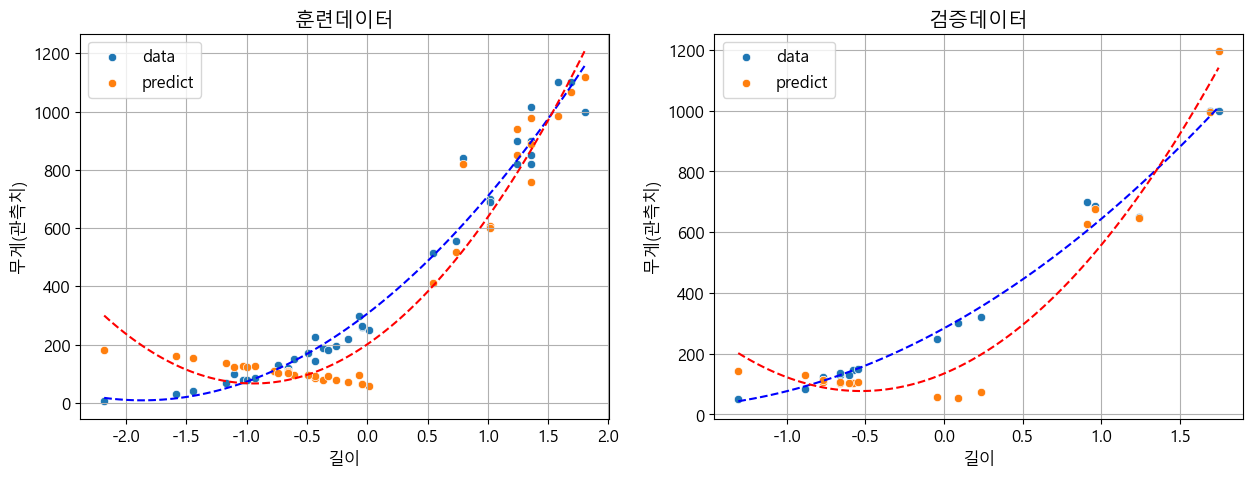

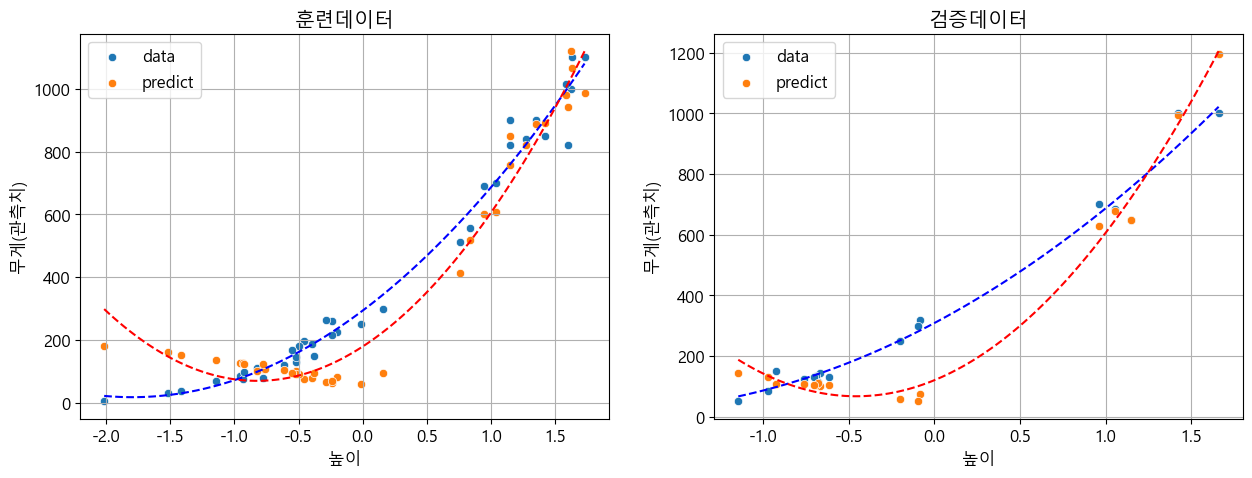

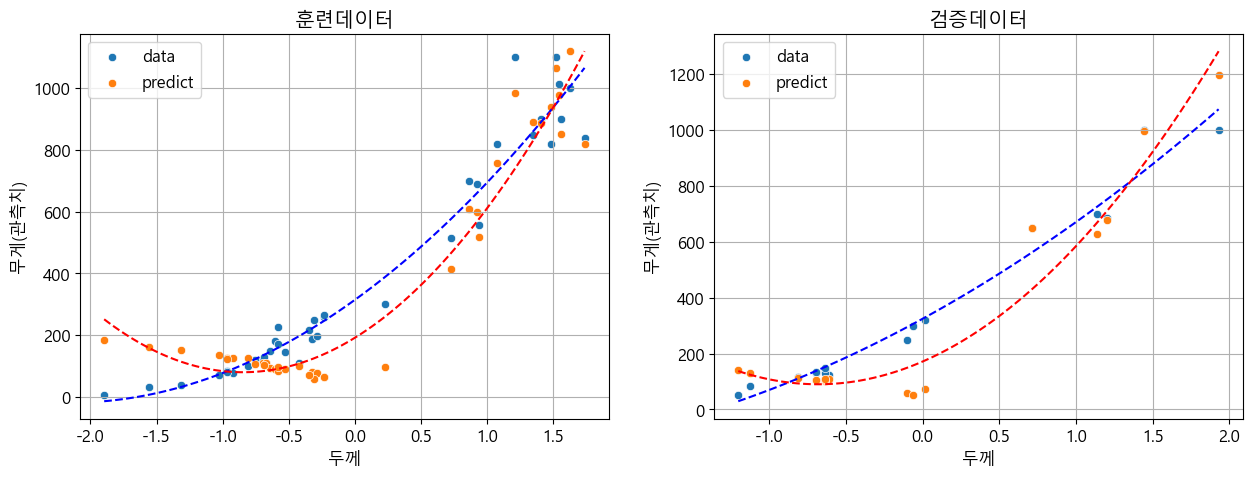

In [34]:
for key in ['길이','높이','두께']:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))

> 표준화 후 다항회귀분석을 한 결과가 더 예측값이 좋은 것으로 보인다.